# Import libraries and mount drive

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!rm DeconvModels.py
!rm training_functions.py
!rm blur_functions.py
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/blur_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_regression_model, train_classification_model
import blur_functions as blur

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory
rm: cannot remove 'blur_functions.py': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/kaggle-sir/'

Mounted at /content/drive


# Dataset Class and create dataloader

In [4]:
class ImageDataset(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/HR')[:20]


        self.y_paths = list(map(lambda img_path: f'{ds_path}/HR/{img_path}', y_imgs))
        self.x_paths = list(map(lambda img_path: f'{ds_path}/LR/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]
        x_path = self.x_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)
        x_img = io.read_image(x_path, io.ImageReadMode.GRAY)

        SIZE = 384
        PAD_SIZE = SIZE//8

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        x_img = T.Resize((SIZE, SIZE))(x_img)
        x_img = x_img / 255.0
        x_img = nn.functional.pad(x_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        return x_img, y_img

In [5]:
data = ImageDataset(base_path)
dataloader = DataLoader(data, batch_size=8, shuffle=False)

x_batch, y_batch = next(iter(dataloader))

x_batch.size(), y_batch.size()

(torch.Size([8, 1, 480, 480]), torch.Size([8, 1, 480, 480]))

(-0.5, 479.5, 479.5, -0.5)

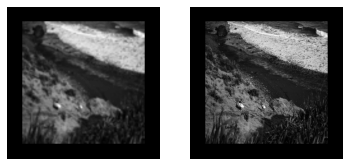

In [6]:
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(y_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

# Initialise Model, Criterion, Optimizer

In [7]:
model = Deconv2D((6, 6))

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train model

In [8]:
history, _ = train_regression_model(model, criterion, optimizer, dataloader, num_epochs=200)

Epoch 0010 loss: 0.08838
Epoch 0020 loss: 0.07964
Epoch 0030 loss: 0.08275
Epoch 0040 loss: 0.08227
Epoch 0050 loss: 0.08229
Epoch 0060 loss: 0.08227
Epoch 0070 loss: 0.08222
Epoch 0080 loss: 0.08217
Epoch 0090 loss: 0.08212
Epoch 0100 loss: 0.08207
Epoch 0110 loss: 0.08202
Epoch 0120 loss: 0.08196
Epoch 0130 loss: 0.08191
Epoch 0140 loss: 0.08186
Epoch 0150 loss: 0.08180
Epoch 0160 loss: 0.08175
Epoch 0170 loss: 0.08170
Epoch 0180 loss: 0.08164
Epoch 0190 loss: 0.08159
Epoch 0200 loss: 0.08154


# Plot results

Text(0.5, 1.0, 'Original')

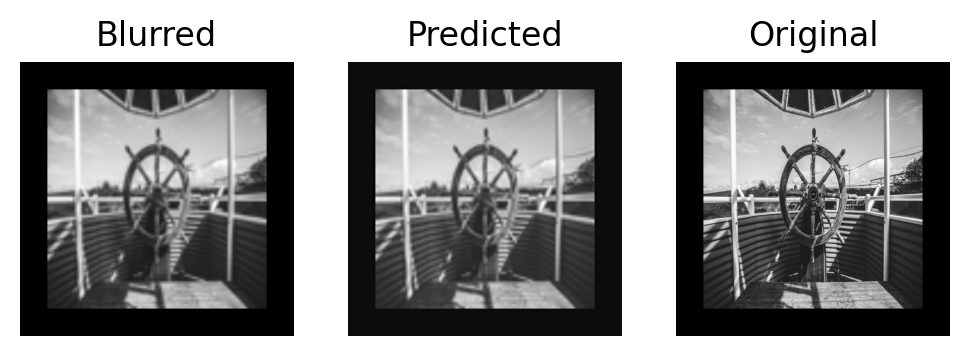

In [9]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

# Testing Conv model

In [12]:
model = nn.Conv2d(1, 1, 3, padding='same')

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
history_conv, _ = train_regression_model(model, criterion, optimizer, dataloader, num_epochs=200)

Epoch 0010 loss: 0.29496
Epoch 0020 loss: 0.22215
Epoch 0030 loss: 0.18548
Epoch 0040 loss: 0.15103
Epoch 0050 loss: 0.11914
Epoch 0060 loss: 0.09403
Epoch 0070 loss: 0.09364
Epoch 0080 loss: 0.09359
Epoch 0090 loss: 0.09360
Epoch 0100 loss: 0.09351
Epoch 0110 loss: 0.09351
Epoch 0120 loss: 0.09340
Epoch 0130 loss: 0.09354
Epoch 0140 loss: 0.09341
Epoch 0150 loss: 0.09321
Epoch 0160 loss: 0.09323
Epoch 0170 loss: 0.09310
Epoch 0180 loss: 0.09314
Epoch 0190 loss: 0.09314
Epoch 0200 loss: 0.09298


Text(0.5, 1.0, 'Original')

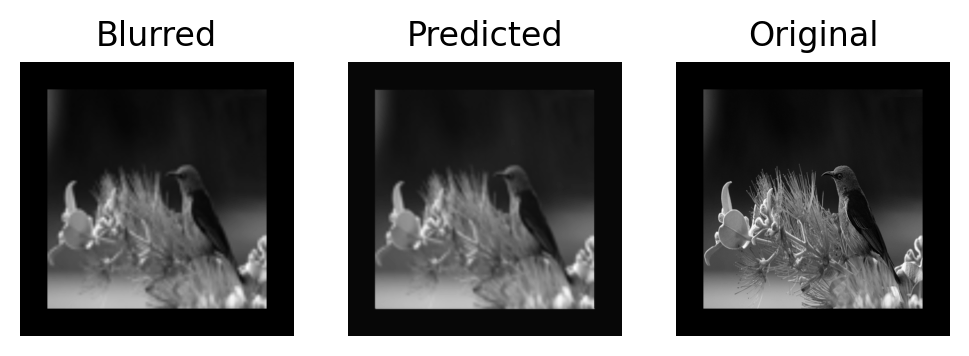

In [14]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

# i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

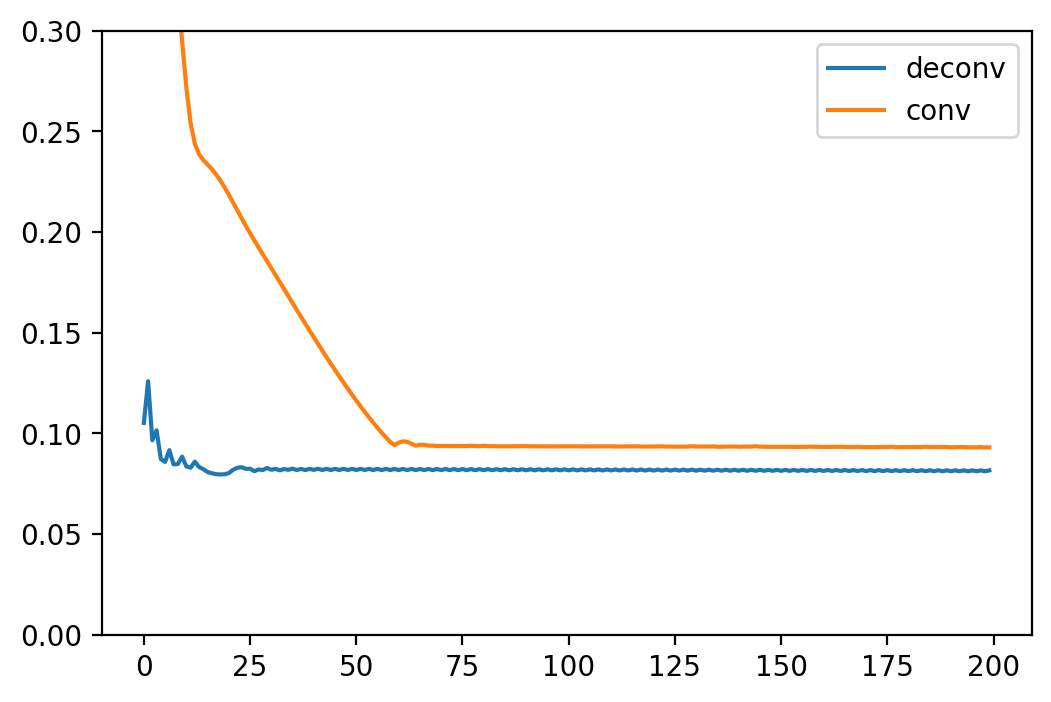

In [16]:
plt.plot(history['loss'], label='deconv')
plt.plot(history_conv['loss'], label='conv')
plt.ylim([0, 0.3])
plt.legend()
plt.show()